## Set up Environment

In [ ]:
%pip install umap-learn hdbscan

In [ ]:
import warnings
## Hide some warnings for cleanliness
warnings.filterwarnings("ignore")

## What is UMAP? (Uniform Manifold Approximation and Projection)
Purpose: Dimensionality Reduction

UMAP is a nonlinear dimensionality reduction technique that helps compress high-dimensional data (like the TF-IDF encoded procedure/diagnosis codes) into a lower-dimensional space while preserving important structure.
How UMAP Works

  *  Graph Construction (High-Dimensional Space)
      -  UMAP first models data as a graph:
            Each point (member) is connected to its nearest neighbors.
            The strength of these connections represents how similar two members are.
       - Think of this as mapping the true relationships between patients based on medical history.

  *  Manifold Approximation
       - The graph is treated as a high-dimensional geometric structure (a manifold).
       - UMAP then learns a lower-dimensional version of this structure.

  * Projection (Low-Dimensional Space)
       - It reconstructs the graph in 2D or 3D, trying to preserve the original structure as much as possible.
        Unlike PCA, which relies on linear projections, UMAP preserves clusters and relationships better.

Why UMAP is Useful Here

- Captures nonlinear relationships between medical codes.
- Preserves local structure, ensuring similar members remain close.
- More effective than PCA for categorical sparse data (like medical codes).

How TF-IDF Works in Your Pipeline

TF-IDF (Term Frequency-Inverse Document Frequency) transforms categorical medical codes into a numerical vector format where:

  -  Similar sets of codes lead to similar vectors.
  -  Rare codes are weighted more to highlight unique patterns.
    Common codes (e.g., general checkups) are downweighted to avoid bias.

1️TF-IDF Formula (Concept)
TF−IDF=TF×IDF
TF−IDF=TF×IDF

Where:

  -  TF (Term Frequency) = How often a code appears in a member’s history.
  - IDF (Inverse Document Frequency) = How rare the code is across all members.

In order to demonstrate how this method could be used in a health insurance environement, we will simulate a dataset containing Medical codes relevant to known members.

## Medical Insurance Simulation

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import hstack
import umap
import hdbscan
import matplotlib.pyplot as plt

# Step 1: Simulate Claims Data
def generate_synthetic_claims(n_claims=5000, n_codes=150000):
    random.seed(42)
    np.random.seed(42)

    # Generate a list of unique codes
    all_codes = [f"CPT{str(i).zfill(5)}" for i in range(1, n_codes+1)]

# Step 1: Simulate Claims Data
def generate_synthetic_claims(n_claims=5000, n_codes=150000):
    random.seed(42)
    np.random.seed(42)

    # Generate a list of unique codes
    all_codes = [f"CPT{str(i).zfill(5)}" for i in range(1, n_codes+1)]

    # Create claims with random codes
    claims = []
    for claim_id in range(n_claims):
        num_codes = random.randint(2, 10)  # Each claim has 2-10 codes
        codes = random.sample(all_codes, num_codes)
        claims.append({"claim_id": claim_id, "codes": " ".join(codes)})

    return pd.DataFrame(claims)

    df = generate_synthetic_claims()

    print(df.head())
    codes = random.sample(all_codes, num_codes)
    claims.append({"claim_id": claim_id, "codes": " ".join(codes)})

    return pd.DataFrame(claims)

df = generate_synthetic_claims()

print(df.head())

   claim_id                                              codes
0         0                         CPT06557 CPT72098 CPT64197
1         1     CPT36580 CPT26869 CPT142965 CPT22791 CPT110605
2         2                                  CPT07812 CPT24562
3         3     CPT60991 CPT132476 CPT06957 CPT147128 CPT52125
4         4  CPT109975 CPT57788 CPT117758 CPT72927 CPT01704...


We can use TF-IDF to transform the codes into a numeric vector, mapping eaaach pathway of each member to their own readable vector for comparison using UMAP and HDBSCAN.

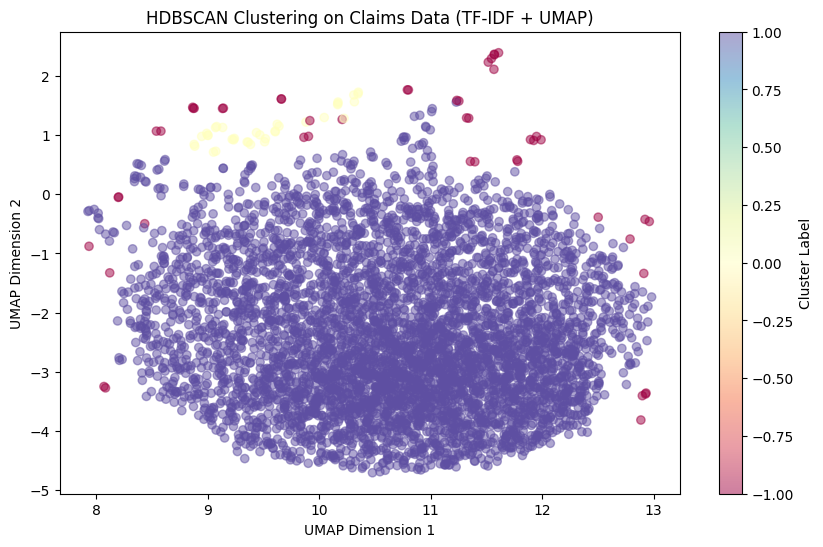

cluster
 1    4916
-1      49
 0      35
Name: count, dtype: int64


In [ ]:
# Step 2: Apply TF-IDF Vectorization
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['codes'])

# Step 3: Reduce Dimensionality with UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_tfidf)

# Step 4: Apply HDBSCAN Clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5)
df['cluster'] = clusterer.fit_predict(X_umap)

# Step 5: Visualize Clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['cluster'], cmap='Spectral', alpha=0.5)
plt.colorbar(scatter, label="Cluster Label")
plt.title("HDBSCAN Clustering on Claims Data (TF-IDF + UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# Display Cluster Counts
print(df['cluster'].value_counts())


## Check for Distortion


What Happens When We Feed TF-IDF Vectors into UMAP?

When we pass high-dimensional TF-IDF vectors into UMAP, it transforms them into a lower-dimensional representation while trying to preserve the underlying structure of the data. Here's how:
Step 1: Constructing the High-Dimensional Graph

 -   Find Nearest Neighbors (k-NN Graph)
        UMAP builds a graph where:
       -   Each member (data point) is a node.
      -  Each node connects to its k-nearest neighbors based on similarity -(measured by cosine distance in the case of TF-IDF).
      -  The edges (connections) between nodes are weighted based on how strongly connected they are (higher weight = more similar).

  -  Define a Probability Distribution Over Distances
      -  UMAP converts these neighbor distances into probabilities.
        Close neighbors have high probabilities, distant points have low probabilities.
        The goal is to preserve relationships, meaning that similar members should stay close in the lower dimension.

 Mapping to Lower Dimensions

   - Optimize a Low-Dimensional Layout
     -   UMAP then tries to reconstruct the same neighbor graph but in a lower-dimensional space (e.g., 2D or 3D).
        It minimizes the difference between the high-dimensional probability structure and the low-dimensional structure.

   - Preserve Local vs. Global Structure
      -  Local structure (neighbor relationships) is prioritized, meaning that clusters in high dimensions will likely remain clusters in low dimensions.
        Global distances are often distorted, meaning that relative positioning between clusters may not be perfect.

 How Much Information is Preserved?

To measure how well UMAP preserves information, we can use:
 Reconstruction Error (Trustworthiness Score)

  -  "Trustworthiness" measures how well UMAP preserved the structure from high to low dimensions.
  -  If points that were close together in high dimensions remain close in low dimensions, the score is high.
    
  We can calculate it like this:

In [ ]:
from sklearn.manifold import trustworthiness

score = trustworthiness(X_tfidf.toarray(), X_umap, n_neighbors=10)
print(f"UMAP Trustworthiness Score: {score:.4f}")

UMAP Trustworthiness Score: 0.5068


This trustworthiness score is okay, but some fine tuning could likely make it better.

## Draw Business Insights

In [ ]:
df['cluster'].value_counts()


,count
cluster,
1,4916
-1,49
0,35


In [ ]:
# Split codes into lists
df['code_list'] = df['codes'].apply(lambda x: x.split())

# Group by cluster and count occurrences of each code
from collections import Counter

cluster_profiles = {}
for cluster_id in df['cluster'].unique():
    cluster_codes = df[df['cluster'] == cluster_id]['code_list'].sum()
    cluster_profiles[cluster_id] = Counter(cluster_codes).most_common(10)

# Display top 10 codes for each cluster
import pprint
pprint.pprint(cluster_profiles)


{-1: [('CPT100788', 4),
      ('CPT97435', 3),
      ('CPT105206', 3),
      ('CPT90537', 2),
      ('CPT69217', 2),
      ('CPT36927', 2),
      ('CPT03755', 2),
      ('CPT26311', 2),
      ('CPT21496', 2),
      ('CPT79161', 2)],
 0: [('CPT75401', 3),
     ('CPT121705', 3),
     ('CPT96870', 2),
     ('CPT78359', 2),
     ('CPT106859', 2),
     ('CPT105005', 2),
     ('CPT106396', 2),
     ('CPT36313', 2),
     ('CPT120739', 2),
     ('CPT129095', 2)],
 1: [('CPT78422', 4),
     ('CPT135481', 4),
     ('CPT66661', 4),
     ('CPT139846', 4),
     ('CPT59757', 4),
     ('CPT25160', 4),
     ('CPT92783', 4),
     ('CPT22687', 4),
     ('CPT44805', 4),
     ('CPT32723', 3)]}


Business Applications

Once clusters are defined, businesses can leverage them in different ways.
A. Risk Stratification & Targeted Interventions

  -  High-risk clusters (e.g., Diabetes, Heart Disease) → Assign care managers to reduce hospitalizations.
  -  Frequent ER users → Encourage preventive care or introduce telemedicine programs.

B. Healthcare Cost & Utilization Analysis

   - Identify high-cost clusters (e.g., frequent imaging, ER visits) and optimize healthcare spending.
   - Adjust insurance pricing & risk models based on segment behaviors.

C. Personalization & Member Engagement

   - Gastrointestinal cluster? → Send targeted nutrition & lifestyle tips.
   - Preventive care cluster? → Offer wellness incentives for checkups.

D. Fraud Detection & Claims Analysis

   - Outlier Cluster (-1)? → Investigate unusual medical patterns (e.g., potential fraud, incorrect billing).
   - Members with unexpected procedures? → Flag for manual review.

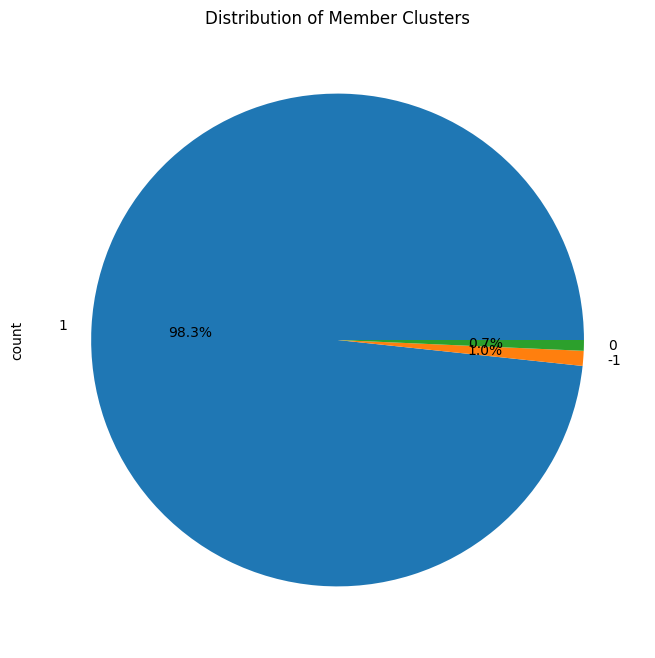

In [ ]:
df['cluster'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title("Distribution of Member Clusters")
plt.show()


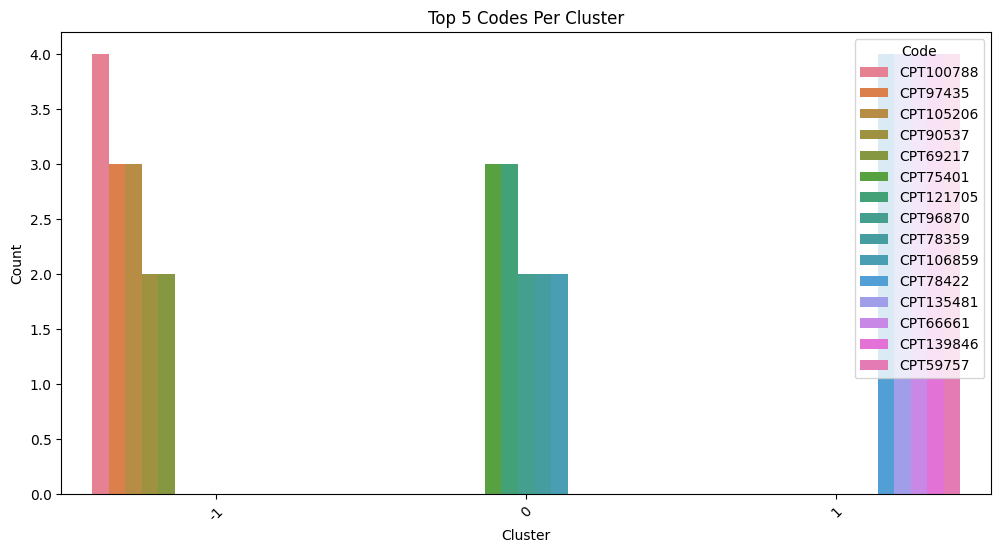

In [ ]:
import seaborn as sns

# Convert cluster_profiles dictionary to DataFrame
cluster_summary = pd.DataFrame([
    {'Cluster': k, 'Code': v[0], 'Count': v[1]} for k, codes in cluster_profiles.items() for v in codes[:5]
])

plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Count', hue='Code', data=cluster_summary)
plt.title("Top 5 Codes Per Cluster")
plt.xticks(rotation=45)
plt.show()


## Beefed up example with multiple features

How to Incorporate Additional Features?

Since we already vectorized medical codes using TF-IDF, we now need to:

 -   Standardize numerical features (e.g., age, total claim cost).
 -  One-hot encode categorical features (e.g., gender).
 -  Combine these new features with the TF-IDF matrix before applying UMAP & HDBSCAN.

In [ ]:

# Step 1: Simulate Extended Member Data with Demographics & Costs
def generate_synthetic_members(n_members=5000, n_codes=150000):
    random.seed(42)
    np.random.seed(42)

    all_codes = [f"CPT{str(i).zfill(5)}" for i in range(1, n_codes+1)]
    genders = ["Male", "Female", "Other"]

    members = []
    for member_id in range(n_members):
        num_codes = random.randint(5, 50)  # Each member has 5-50 codes over time
        codes = random.sample(all_codes, num_codes)
        age = random.randint(18, 90)  # Member age
        gender = random.choice(genders)  # Gender category
        total_claim_cost = round(random.uniform(500, 50000), 2)  # Total claim cost ($)

        members.append({"member_id": member_id, "codes": " ".join(codes),
                        "age": age, "gender": gender, "total_claim_cost": total_claim_cost})

    return pd.DataFrame(members)

df = generate_synthetic_members()

# Step 2: Apply TF-IDF Vectorization (Medical History)
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['codes'])

# Step 3: Standardize Numerical Features (Age, Claim Cost)
scaler = StandardScaler()
X_numerical = scaler.fit_transform(df[['age', 'total_claim_cost']])

# Step 4: One-Hot Encode Categorical Features (Gender)
encoder = OneHotEncoder(sparse_output=False)
X_categorical = encoder.fit_transform(df[['gender']])

# Step 5: Combine All Features (TF-IDF + Age + Cost + Gender)
X_combined = hstack([X_tfidf, X_numerical, X_categorical])

# Step 6: Reduce Dimensionality with UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_combined.toarray())  # Convert sparse matrix to array

# Step 7: Apply HDBSCAN Clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=5)
df['cluster'] = clusterer.fit_predict(X_umap)

# Step 8: Visualize Clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['cluster'], cmap='Spectral', alpha=0.5)
plt.colorbar(scatter, label="Cluster Label")
plt.title("HDBSCAN Clustering with Medical + Demographic + Financial Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# Display Cluster Counts
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Clustered Members", dataframe=df)


How This Improves the Clustering
  - Before (Only Medical Codes)
  -  Clustering was purely based on diagnosis & procedure codes.
  - Missed cost variations, age group patterns, gender differences.

Now (Medical + Demographics + Costs)

- Captures cost differences (high vs. low claim spenders).

- Segments members by age group (young, middle-aged, elderly).

- Accounts for gender-based medical patterns.

- Better business insights (financial + medical grouping).

## Key UMAP Parameters & Their Effects


| Parameter      | Effect                                  | When to Change                                       |
|--------------|--------------------------------|----------------------------------|
| **n_components**  | Number of dimensions (default = 2) | Increase to retain more info, decrease for better visualization |
| **n_neighbors**   | Controls local vs. global structure | Low = captures fine details, high = preserves broader structure |
| **min_dist**      | Controls how tightly points are packed | Low = compact clusters, high = more spread out |
| **metric**        | Distance measure (default = "euclidean") | Use "cosine" for sparse data (like TF-IDF) |




## Final Code Example (Complete)

We can now include steps showing how one might tune this method for better performance and more interpretable clusters.

```
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import hstack
import umap
import hdbscan
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.manifold import trustworthiness

# Step 1: Generate Synthetic Member Data
def generate_synthetic_members(n_members=5000, n_codes=150000):
    random.seed(42)
    np.random.seed(42)

    all_codes = [f"CPT{str(i).zfill(5)}" for i in range(1, n_codes+1)]
    genders = ["Male", "Female", "Other"]

    members = []
    for member_id in range(n_members):
        num_codes = random.randint(5, 50)  # Each member has 5-50 codes over time
        codes = random.sample(all_codes, num_codes)
        age = random.randint(18, 90)  # Member age
        gender = random.choice(genders)  # Gender category
        total_claim_cost = round(random.uniform(500, 50000), 2)  # Total claim cost ($)

        members.append({"member_id": member_id, "codes": " ".join(codes),
                        "age": age, "gender": gender, "total_claim_cost": total_claim_cost})

    return pd.DataFrame(members)

df = generate_synthetic_members()

# Step 2: Apply TF-IDF Vectorization (Medical History)
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['codes'])

# Step 3: Standardize Numerical Features (Age, Claim Cost)
scaler = StandardScaler()
X_numerical = scaler.fit_transform(df[['age', 'total_claim_cost']])

# Step 4: One-Hot Encode Categorical Features (Gender)
encoder = OneHotEncoder(sparse_output=False)
X_categorical = encoder.fit_transform(df[['gender']])

# Step 5: Combine All Features (TF-IDF + Age + Cost + Gender)
X_combined = hstack([X_tfidf, X_numerical, X_categorical])


# Step 6: Define Hyperparameter Search Space for UMAP + HDBSCAN
search_space = {
    "n_neighbors": hp.choice("n_neighbors", [5, 15, 30, 50, 100]),
    "min_dist": hp.uniform("min_dist", 0.01, 0.5),
    "n_components": hp.choice("n_components", [2, 5, 10]),
    "min_cluster_size": hp.choice("min_cluster_size", [20, 50, 100, 200]),
}

# Step 7: Define the Objective Function for Hyperopt
def objective(params):
    """Optimize UMAP and HDBSCAN hyperparameters based on Trustworthiness Score."""

    # Apply UMAP for Dimensionality Reduction
    reducer = umap.UMAP(
        n_neighbors=params["n_neighbors"],
        min_dist=params["min_dist"],
        n_components=params["n_components"],
        metric="cosine",  # Best metric for TF-IDF
        random_state=42
    )
    X_umap = reducer.fit_transform(X_combined.toarray())  # Convert sparse matrix to dense

    # Apply HDBSCAN for Clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=params["min_cluster_size"], min_samples=5)
    clusters = clusterer.fit_predict(X_umap)

    # Compute Trustworthiness Score (Higher is better)
    score = trustworthiness(X_combined.toarray(), X_umap, n_neighbors=10)

    print(f"Params: {params} → Trustworthiness Score: {score:.4f}")

    return {"loss": -score, "status": STATUS_OK}

# Step 8: Run Hyperparameter Optimization
trials = Trials()
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,  # Number of optimization iterations
    trials=trials
)

# Step 9: Apply Best UMAP and HDBSCAN Parameters
optimal_umap = umap.UMAP(
    n_neighbors=[5, 15, 30, 50, 100][best_params["n_neighbors"]],
    min_dist=best_params["min_dist"],
    n_components=[2, 5, 10][best_params["n_components"]],
    metric="cosine",
    random_state=42
)
X_umap = optimal_umap.fit_transform(X_combined.toarray())

optimal_hdbscan = hdbscan.HDBSCAN(min_cluster_size=[20, 50, 100, 200][best_params["min_cluster_size"]], min_samples=5)
df['cluster'] = optimal_hdbscan.fit_predict(X_umap)

# Step 10: Visualize Best Clustering Results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['cluster'], cmap='Spectral', alpha=0.5)
plt.colorbar(scatter, label="Cluster Label")
plt.title("Optimized HDBSCAN Clustering with Medical + Demographic + Financial Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# Display Optimized Parameters
print("Best UMAP & HDBSCAN Parameters:", best_params)
```

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

